# IMPORT

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# PREPROCESS

In [56]:
path = r"C:\Users\Nasip-PC\Desktop\Dosyalar\Kodlar\Das Reich\AlgoV2\Algorithms\Data intensive\fvg_mean_threshold_model.csv"
df = pd.read_csv(path)

# Convert 'Local time' to datetime
df['Local time'] = pd.to_datetime(df['Local time'], format='%Y-%m-%d %H:%M:%S')

# Calculate EMA1000
df['EMA1000'] = df['Close'].ewm(span=1000, adjust=False).mean()

# Calculate Distance
df['Distance'] = df['Close'] - df['EMA1000']

# Add previous 10 Distance variables
for i in range(1, 11):
    df[f'Distance_lag_{i}'] = df['Distance'].shift(i)

# Calculate Body as Close - Open
df['Body'] = df['Close'] - df['Open']

# Drop unnecessary columns
df = df.drop(columns=['Open', 'High', 'Low', 'Close', 'EMA1000', 'Local time', 'Volume'])

# Display the resulting DataFrame
print(df)


         Position Type  Is Profitable   Distance  Distance_lag_1  \
0                    0              0   0.000000             NaN   
1                    0              0  -6.387213        0.000000   
2                    0              0  -5.645910       -6.387213   
3                    0              0  -5.574749       -5.645910   
4                    0              0 -12.669385       -5.574749   
...                ...            ...        ...             ...   
1019745              0              0   5.355230        9.821951   
1019746              0              0   4.323574        5.355230   
1019747              0              0   0.388796        4.323574   
1019748              0              0   1.354085        0.388796   
1019749              0              0   0.808467        1.354085   

         Distance_lag_2  Distance_lag_3  Distance_lag_4  Distance_lag_5  \
0                   NaN             NaN             NaN             NaN   
1                   NaN          

In [57]:
# Display the counts
print(df['Is Profitable'].value_counts())

# Drop all rows where 'Is Profitable' equals 0
df = df[df['Is Profitable'] != 0]

print("Dropping Non Trade Rows ...")

# Reset the index if needed
df = df.reset_index(drop=True)

# Display the counts
print(df['Is Profitable'].value_counts())

Is Profitable
 0    965531
-1     38819
 1     15400
Name: count, dtype: int64
Dropping Non Trade Rows ...
Is Profitable
-1    38819
 1    15400
Name: count, dtype: int64


In [58]:


# Count the number of rows where 'Is Profitable' equals -1 and 1
count_minus_1 = df[df['Is Profitable'] == -1].shape[0]
count_1 = df[df['Is Profitable'] == 1].shape[0]

# Calculate the number of rows to drop
rows_to_drop = count_minus_1 - count_1

if rows_to_drop > 0:
    # Filter rows where 'Is Profitable' equals -1
    minus_1_rows = df[df['Is Profitable'] == -1]

    # Randomly select rows to drop
    rows_to_drop_indices = np.random.choice(minus_1_rows.index, rows_to_drop, replace=False)

    # Drop the selected rows
    df = df.drop(rows_to_drop_indices)

# Reset the index if needed
df = df.reset_index(drop=True)

print(df['Is Profitable'].value_counts())

Is Profitable
 1    15400
-1    15400
Name: count, dtype: int64


In [70]:
df

,Position Type,Is Profitable,Distance,Distance_lag_1,Distance_lag_2,Distance_lag_3,Distance_lag_4,Distance_lag_5,Distance_lag_6,Distance_lag_7,Distance_lag_8,Distance_lag_9,Distance_lag_10,Body
0,-1,1,-14.782839,-16.612434,-18.665692,-17.943061,-18.148983,-16.655317,-15.228661,-13.349149,-12.625874,-14.811151,-12.620803,1.760
1,-1,0,-20.164616,-22.364985,-22.479760,-18.264765,-15.211331,-15.511784,-14.782839,-16.612434,-18.665692,-17.943061,-18.148983,2.112
2,-1,0,11.144170,9.104481,7.734708,9.880193,10.069973,13.780133,14.637721,12.857026,11.762766,13.146315,13.232634,1.960
3,-1,1,11.432109,13.484996,16.751993,17.125531,17.159816,11.144170,9.104481,7.734708,9.880193,10.069973,13.780133,-2.620
4,-1,1,20.656422,22.057776,23.091936,24.218166,18.816651,18.094322,18.628546,19.907841,15.987696,18.059704,15.865859,-1.368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30795,-1,1,18.977639,17.138632,18.483944,15.041949,13.317063,14.665724,15.685085,18.260486,19.142044,18.045366,16.359493,1.778
30796,-1,0,36.316577,39.866283,44.556095,36.134296,32.729637,29.940162,30.200102,28.382563,26.306385,26.004051,29.156111,-3.488
30797,-1,1,29.584860,25.299089,25.526738,24.533842,25.226959,34.369464,34.257271,33.327854,36.316577,39.866283,44.556095,4.212
30798,-1,1,13.961982,15.299934,13.196564,17.222984,18.481464,18.761464,19.554024,18.060172,18.763328,17.856892,17.447642,-1.111


# Train Model

In [59]:
# Update Is Profitable to have binary classes (convert -1 to 0)
df['Is Profitable'] = df['Is Profitable'].replace(-1, 0)

# Drop unused columns
X = df.drop(columns=['Is Profitable'])
y = df['Is Profitable']


In [71]:
# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X[: int(95 * len(X)/ 100)], X[int(80 * len(X)/ 100) : ]
y_train, y_test = y[: int(95 * len(X)/ 100)], y[int(80 * len(X)/ 100) : ]

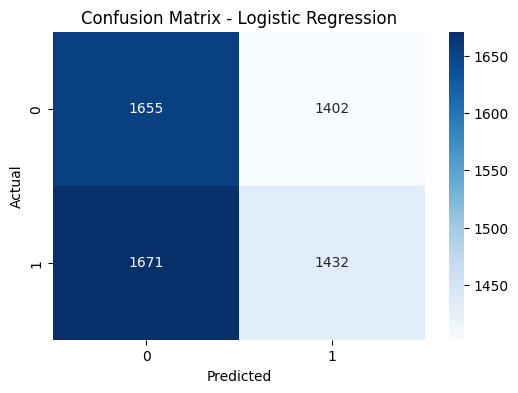

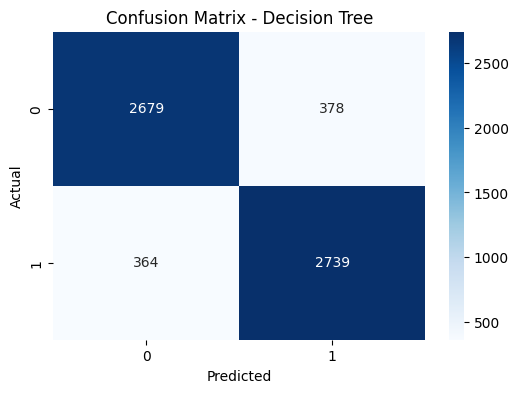

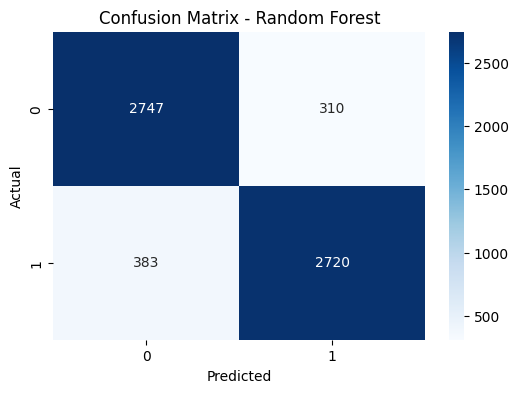

c:\Users\Nasip-PC\anaconda3\envs\olympus\lib\site-packages\xgboost\core.py:158: UserWarning: [15:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


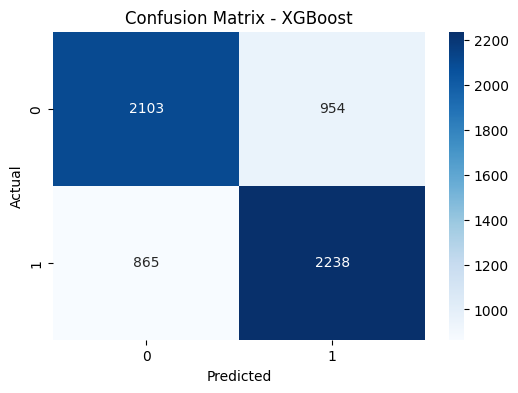

[LightGBM] [Info] Number of positive: 14617, number of negative: 14643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 29260, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499556 -> initscore=-0.001777
[LightGBM] [Info] Start training from score -0.001777


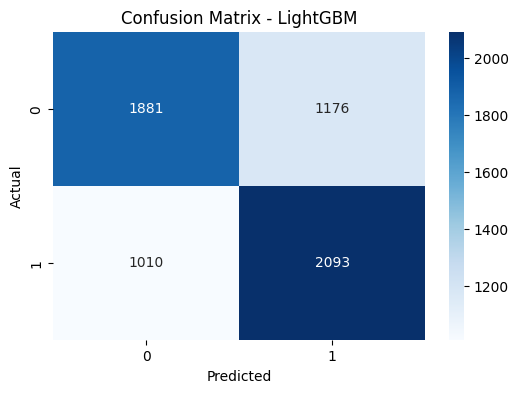

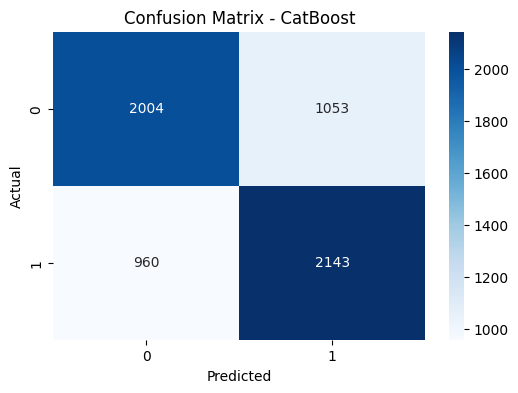

Model: Logistic Regression
Confusion Matrix:
[[1655 1402]
 [1671 1432]]
Precision: 0.5015
Recall: 0.5011
F1 Score: 0.5003

Model: Decision Tree
Confusion Matrix:
[[2679  378]
 [ 364 2739]]
Precision: 0.8795
Recall: 0.8795
F1 Score: 0.8795

Model: Random Forest
Confusion Matrix:
[[2747  310]
 [ 383 2720]]
Precision: 0.8877
Recall: 0.8875
F1 Score: 0.8875

Model: XGBoost
Confusion Matrix:
[[2103  954]
 [ 865 2238]]
Precision: 0.7048
Recall: 0.7047
F1 Score: 0.7046

Model: LightGBM
Confusion Matrix:
[[1881 1176]
 [1010 2093]]
Precision: 0.6454
Recall: 0.6451
F1 Score: 0.6448

Model: CatBoost
Confusion Matrix:
[[2004 1053]
 [ 960 2143]]
Precision: 0.6733
Recall: 0.6732
F1 Score: 0.6731



In [69]:

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Evaluate models
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results.append({
        "Model": name,
        "Confusion Matrix": cm,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Display results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}\n")


# Backtest

## Functions

In [133]:
# Dataset path
path1 = r"C:\Users\Nasip-PC\Desktop\Dosyalar\Kodlar\Das Reich\AlgoV2\Datasets\NASDAQ\USATECH_ADJUSTED_30.09.2021-21.09.2024.csv"
# Read the dataset

df = pd.read_csv(path1)

# # 'Local time' kolonundaki zaman dilimini temizle ve datetime formatına dönüştür
# df['Local time'] = df['Local time'].str.split(' GMT').str[0]  # ' GMT+0300' kısmını çıkarır
# df['Local time'] = pd.to_datetime(df['Local time'], format='%d.%m.%Y %H:%M:%S.%f')  # Doğru formatı belirtin
df['Local time'] = pd.to_datetime(df['Local time'], format='%Y-%m-%d %H:%M:%S')

# Set the index to 'Local time' for mplfinance compatibility
df_chart = df.copy()
df_chart.set_index('Local time', inplace=True)


def check_for_fvg(df, current_index):
    
    """ 
    BULLISH FVG -> 1 
    BEARISH FVG -> - 1 
    NO FVG -> 0 
    
    
    """
    
    # Get the previous candle's high and low
    prev_2_high = df.iloc[current_index - 2]['High']
    prev_2_low = df.iloc[current_index - 2]['Low']
    
    # Get the current candle's high and low
    current_high = df.iloc[current_index]['High']
    current_low = df.iloc[current_index]['Low']

    fvg_body_threshold = 1
    fvg_wick_threshold = 1
    
    current_body = abs(df.iloc[current_index - 1]['Close'] - df.iloc[current_index - 1]['Open'])
    
    # Check for a Bullish FVG (current candle's low is higher than the previous candle's high)
    if current_body > fvg_body_threshold and current_low - prev_2_high > fvg_wick_threshold:
        return 1
    
    # Check for a Bearish FVG (current candle's high is lower than the previous candle's low)
    if current_body > fvg_body_threshold and prev_2_low - current_high > fvg_wick_threshold:
        return - 1
    
    return 0 

def predict_row(row, scaler):
    # Scale the input row
    row_scaled = scaler.transform([row])  # Ensure row is in 2D format

    # Make prediction
    prediction = model.predict(row_scaled)
    
    return prediction[0]  # Extract the prediction from the array


def calculate_max_drawdown(values):
    peak = values[0]
    max_drawdown = 0
    
    for value in values:
        # Update the peak value if the current value is greater than the previous peak
        peak = max(peak, value)
        
        # Calculate the drawdown at the current value
        drawdown = (peak - value) 
        
        # Update the max drawdown if the current drawdown is larger
        max_drawdown = max(max_drawdown, drawdown)
    
    return max_drawdown

GRAPH_EXTEND = 10
RISK_REWARD_RATIO = 1
POSITION_TP_SL_RANGE = 20

# LONG İŞLEM SONRASI DURUMU KONTROL EDEN KOD
def open_long_position(df, df_chart, entry_index,fvg_index, entry_price, balance, tp_counter, sl_counter, lot_size,total_profit_loss, 
                            visualize = True, position_tp_sl_range = POSITION_TP_SL_RANGE, risk_reward_ration = RISK_REWARD_RATIO,graph_extend = GRAPH_EXTEND, total_rr = None):
    
    stop_price = df.iloc[entry_index - position_tp_sl_range : entry_index + 1]["Low"].min()
    tp_price = entry_price + abs(entry_price - stop_price) * risk_reward_ration


    """  ADJUST tp_price, stop_price LEVELS IN HERE """


    for trade_index in range(entry_index + 1, len(df)):
        if df.iloc[trade_index]["Low"] < stop_price:
            change_rate = 1 - (abs(entry_price - stop_price) / entry_price)
            balance *= change_rate
            sl_counter += 1
            
            total_rr -= 1
        
            total_profit_loss = total_profit_loss - (abs(stop_price - entry_price) * lot_size ) 

            break

        elif df.iloc[trade_index]["High"] > tp_price:

            change_rate = 1 + (abs(tp_price - entry_price) / entry_price)
            balance *= change_rate
            tp_counter += 1

            total_rr += risk_reward_ration

            total_profit_loss = total_profit_loss + (abs(tp_price - entry_price) * lot_size ) 

            break
        
        # BURDA FVG'Yİ KIRDIĞI İÇİN İŞLEMİ KAPATIYORUZ
        elif df.iloc[trade_index]["Close"] < df.iloc[fvg_index - 2]["High"]:
            change_rate = 1 - (abs(entry_price - df.iloc[trade_index]["Close"]) / entry_price)
            balance *= change_rate
            sl_counter += 1

            total_rr -= abs(entry_price - df.iloc[trade_index]["Close"]) / (abs(entry_price - stop_price))

            total_profit_loss = total_profit_loss - (abs(stop_price - entry_price) * lot_size ) 

            #print("BREAK THE CYCLE MORTY")
            
            break

    return balance, tp_counter , sl_counter, trade_index, stop_price, tp_price,change_rate, total_profit_loss, total_rr

# SHORT İŞLEM SONRASI DURUMU KONTROL EDEN KOD
def open_short_position(df, df_chart, entry_index,fvg_index, entry_price, balance, tp_counter, sl_counter, lot_size,total_profit_loss, 
                            visualize = True, position_tp_sl_range = POSITION_TP_SL_RANGE, risk_reward_ration = RISK_REWARD_RATIO,graph_extend = GRAPH_EXTEND, total_rr = None):
    
    stop_price = df.iloc[entry_index - position_tp_sl_range : entry_index + 1]["High"].max()
    tp_price = entry_price - abs(stop_price - entry_price) * risk_reward_ration

    for trade_index in range(entry_index + 1, len(df)):
        if df.iloc[trade_index]["High"] > stop_price:
            change_rate = 1 - (abs(stop_price - entry_price) / entry_price)
            balance *= change_rate
            sl_counter += 1
            total_rr -= 1
            total_profit_loss = total_profit_loss - (abs(stop_price - entry_price) * lot_size ) 
            break

        elif df.iloc[trade_index]["Low"] < tp_price:

            change_rate = 1 + (abs(entry_price - tp_price) / entry_price)
            balance *= change_rate
            tp_counter += 1

            total_rr += risk_reward_ration

            total_profit_loss = total_profit_loss + (abs(tp_price - entry_price) * lot_size ) 

            break
        

        # BURDA FVG'Yİ KIRDIĞI İÇİN İŞLEMİ KAPATIYORUZ
        elif df.iloc[trade_index]["Close"] > df.iloc[fvg_index - 2]["Low"]:
            change_rate = 1 - (abs(df.iloc[trade_index]["Close"] - entry_price) / entry_price)
            balance *= change_rate
            sl_counter += 1

            total_profit_loss = total_profit_loss - (abs(stop_price - entry_price) * lot_size )
            total_rr -= abs(entry_price - df.iloc[trade_index]["Close"]) / (abs(entry_price - stop_price))
            
            break
        


    return balance, tp_counter , sl_counter, trade_index, stop_price, tp_price,change_rate, total_profit_loss, total_rr

## Process

In [128]:
path = r"C:\Users\Nasip-PC\Desktop\Dosyalar\Kodlar\Das Reich\AlgoV2\Algorithms\Data intensive\fvg_mean_threshold_model.csv"
test_df = pd.read_csv(path)

# Convert 'Local time' to datetime
test_df['Local time'] = pd.to_datetime(test_df['Local time'], format='%Y-%m-%d %H:%M:%S')

# Calculate EMA1000
test_df['EMA1000'] = test_df['Close'].ewm(span=1000, adjust=False).mean()

# Calculate Distance
test_df['Distance'] = test_df['Close'] - test_df['EMA1000']

# Add previous 10 Distance variables
for i in range(1, 11):
    test_df[f'Distance_lag_{i}'] = test_df['Distance'].shift(i)

# Calculate Body as Close - Open
test_df['Body'] = test_df['Close'] - test_df['Open']

# Drop unnecessary columns
test_df = test_df.drop(columns=['Open', 'High', 'Low', 'Close', 'EMA1000', 'Local time', 'Volume'])

test_df = test_df[int(30 * len(test_df) / 100):int(35 * len(test_df) / 100) ]
df = df[int(30 * len(test_df) / 100):int(35 * len(test_df) / 100) ]
test_df.drop(["Is Profitable"] ,inplace=True, axis = 1)


In [134]:
current_index = 2
balance = 100
lot_size = 0.01
total_profit_loss = 0

tp_counter = 0
sl_counter = 0
balances = [balance]
pl_values = []

tp_trades = []
sl_trades = []

low_liqs = []
high_liqs = []

long_trades = 0
short_trades = 0
RR = 1



fr_range = 10
total_rr = 0
total_rr_list = [total_rr]
# Define the start and end time for the check


while current_index < len(df) - 1000:
    current_index += 1

    """ LONG POSITION """
    if check_for_fvg(df, current_index) == 1 and predict_row(test_df.iloc[current_index], scaler) == 1:
        fvg_index = current_index
        fvg_upper_bound = df.iloc[current_index]["Low"]
        fvg_lower_bound = df.iloc[current_index - 2]["High"]

        fr_check_range = current_index + fr_range

        while current_index < fr_check_range:
            current_index += 1

            if df.iloc[current_index]["Close"] < fvg_lower_bound:
                break

            if check_for_fvg(df,current_index) == 1 :
                current_index -= 1
                break


            if df.iloc[current_index]["Low"] <  (fvg_upper_bound + fvg_lower_bound) / 2:
                long_trades += 1
                # LİMİT EMRİ BULLİSH FVG HİGH BOUND'A ATIYORUZ
                entry_price = (fvg_upper_bound + fvg_lower_bound) / 2
                entry_index = current_index

                tp_prev = tp_counter    
                print(total_rr)

                balance, tp_counter , sl_counter, trade_index, stop_price, tp_price,change_rate, total_profit_loss, total_rr   = open_long_position(df, df_chart, entry_index,fvg_index, entry_price, balance, 
                        tp_counter, sl_counter, lot_size,total_profit_loss, 
                        visualize = False, position_tp_sl_range = POSITION_TP_SL_RANGE, risk_reward_ration = RISK_REWARD_RATIO,graph_extend = GRAPH_EXTEND, total_rr = total_rr )


                title = F"""
LONG
FVG Time : {df.iloc[fvg_index]['Local time']} , Entry Time : {df.iloc[current_index]['Local time']} , Exit Time : {df.iloc[trade_index]['Local time']} 
Entry Price : {entry_price}, Stop Price : {stop_price}, Take Profit Price : {tp_price}
TOTAL RR : {total_rr} Drawdown : {calculate_max_drawdown(total_rr_list):.2f}
"""              
                #print(title)

                balances.append(balance)
                total_rr_list.append(total_rr)

                
                break

    """ SHORT POSITION  """
    if check_for_fvg(df, current_index) == -1 and predict_row(test_df.iloc[current_index], scaler) == 1:
        fvg_index = current_index

        fvg_lower_bound = df.iloc[current_index]["High"]
        fvg_upper_bound = df.iloc[current_index - 2]["Low"]

        fr_check_range = current_index + fr_range

        while current_index < fr_check_range:
            current_index += 1

            if df.iloc[current_index]["Close"] > fvg_upper_bound:
                break

            if check_for_fvg(df,current_index) == -1:
                current_index -= 1
                break

            if df.iloc[current_index]["High"] > (fvg_upper_bound + fvg_lower_bound) / 2:
                
                
                short_trades += 1
                # LİMİT EMRİ BULLİSH FVG HİGH BOUND'A ATIYORUZ
                entry_price = (fvg_upper_bound + fvg_lower_bound) / 2
                entry_index = current_index

                tp_prev = tp_counter

                balance, tp_counter , sl_counter, trade_index, stop_price, tp_price,change_rate, total_profit_loss, total_rr   = open_short_position(df, df_chart, entry_index,fvg_index, entry_price, balance, 
                        tp_counter, sl_counter, lot_size,total_profit_loss, 
                        visualize = False, position_tp_sl_range = POSITION_TP_SL_RANGE, risk_reward_ration = RISK_REWARD_RATIO,graph_extend = GRAPH_EXTEND, total_rr = total_rr  )
                
                
                title = F"""
SHORT
FVG Time : {df.iloc[fvg_index]['Local time']} , Entry Time : {df.iloc[current_index]['Local time']} , Exit Time : {df.iloc[trade_index]['Local time']} 
Entry Price : {entry_price}, Stop Price : {stop_price}, Take Profit Price : {tp_price}
TOTAL RR : {total_rr} Drawdown : {calculate_max_drawdown(total_rr_list):.2f}
"""      
                #print(title)
                balances.append(balance)
                total_rr_list.append(total_rr)


                break


title = F"TOTAL RR: {total_rr} TP:{tp_counter} SL:{sl_counter} WIN RATE:{(tp_counter / (tp_counter + sl_counter)):.2f}Drawdown: {calculate_max_drawdown(total_rr_list):.2f}"
plt.figure(figsize=(10, 5))  # Set the figure siz;e
plt.plot(total_rr_list, linestyle='-', color='black', label='Balances')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title(title)
plt.grid(True)  # Add a grid for better readability

# Save the plot as an image
plt.savefig(f"test_df.png", dpi=300)  # Save with high resolution
plt.show()  # Display the plot


-0.4083410432493506
-0.9671781452335647
-1.0907669747046487
-1.3869285908663354
-0.38692859086633535
-1.195111538672026
-1.2718609743379714
-1.2992816137736685
-0.9068626259598869
-0.2733394530897418
-0.8538981978275015
-1.1454039893331944
-0.5908459242249315
-0.00872337295136738
1.9912766270486326
1.898101780422924
0.7909851086862545
0.28451198196993266
0.16234003626850443
0.26860570042885046
-0.02481735696069398
-0.7247940778258973
0.10131061286065596
0.7358035993279028
1.0443611879862364
1.0058755417533207
2.005875541753321
1.5789200996233665
2.5789200996233665
3.5789200996233665
3.3701473845647913
3.2649136352632158
4.603344665445647
6.414243848006876
6.099328701911962
6.097609764024408
5.848759071395606
6.848759071395606
6.739905104358484
6.252693687631873
8.252693687631872
7.896899708653799
7.69084309245885
7.485163890616906
8.485163890616906
6.807690387178828
7.807690387178828
8.656873864604405
7.731820836086859
7.509299767411949
7.448269655315837
7.368115694886374
8.36811569488

IndexError: single positional indexer is out-of-bounds

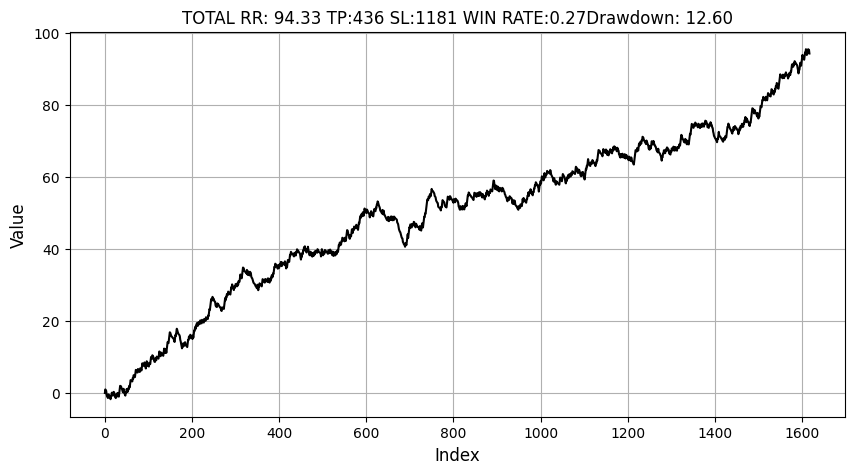

In [136]:

title = F"TOTAL RR: {total_rr:.2f} TP:{tp_counter} SL:{sl_counter} WIN RATE:{(tp_counter / (tp_counter + sl_counter)):.2f}Drawdown: {calculate_max_drawdown(total_rr_list):.2f}"
plt.figure(figsize=(10, 5))  # Set the figure siz;e
plt.plot(total_rr_list, linestyle='-', color='black', label='Balances')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title(title)
plt.grid(True)  # Add a grid for better readability

# Save the plot as an image
plt.savefig(f"test_df.png", dpi=300)  # Save with high resolution
plt.show()  # Display the plot

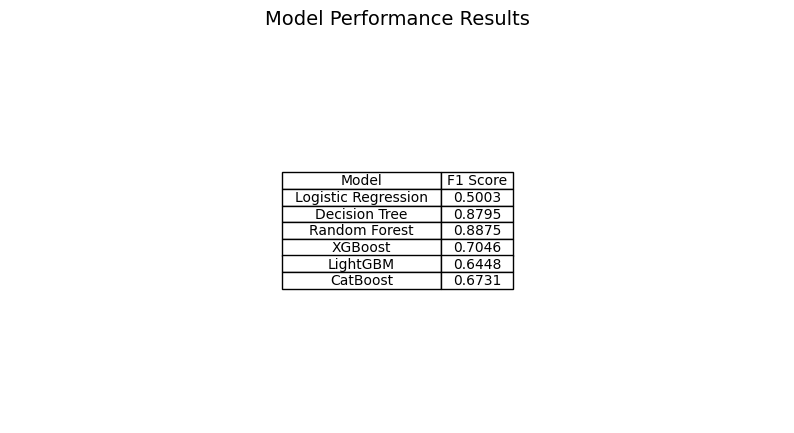

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Model results data
model_results = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"],
    "Precision": [0.    15, 0.8795, 0.8877, 0.7048, 0.6454, 0.6733],
    "Recall": [0.5011, 0.8795, 0.8875, 0.7047, 0.6451, 0.6732],
    "F1 Score": [0.5003, 0.8795, 0.8875, 0.7046, 0.6448, 0.6731]
}

# Create a DataFrame
df_results = pd.DataFrame(model_results)

# Plotting the table
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_results.values, colLabels=df_results.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df_results.columns))))

plt.title("Model Performance Results", fontsize=14, pad=10)
plt.show()

